## Segmentation experiments

In [89]:
import time
import cv2
import os
import pytesseract
from pytesseract import Output
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
#from deslant_img import deslant_img
import imutils

from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line

pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'

# Hyperparameters
confidence_threshold = 60
width_tolerance = 0.3
min_entry_width = 10
max_entry_width = 250

# Parameters
input_dir = "Dataset/Ownership/jpg"
output_dir = "Dataset/Ownership/ocr/"
cropped_dir = "Dataset/Ownership/cropped"
log_dir = "Dataset/Ownership/"

TODO:
- Cases where building is not detected
- Test stability for more images

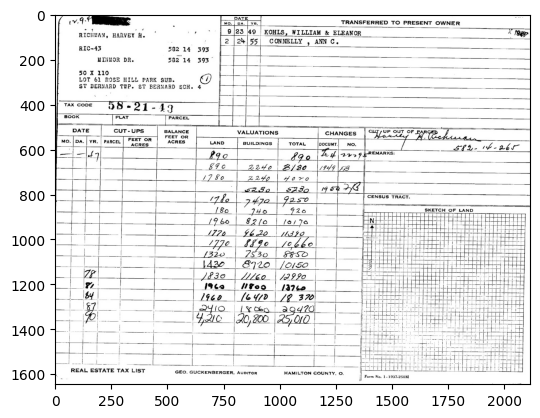

In [60]:
img = cv2.imread(f'{cropped_dir}/5820014039300.jpg')

plt.imshow(img)

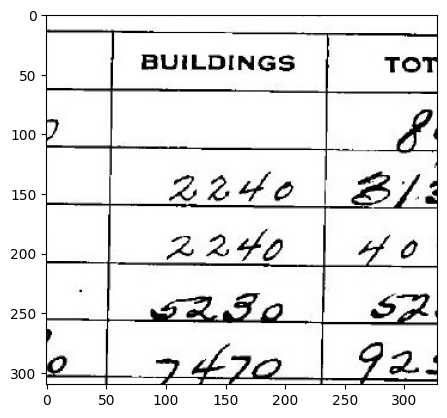

In [154]:
# Get locations of the text from Pytesseract
d = pytesseract.image_to_data(img, output_type=Output.DICT)

building_index, total_index, land_index, valuation_index = -999, -999, -999, -999

for index, text in enumerate(d['text']):
    if text.lower() == "buildings":
        building_index = index
    if text.lower() == "total":
        total_index = index
    if text.lower() == 'land':
        land_index = index
    if text.lower() == 'valuations':
        valuation_index = index


# Crop image if building found
if building_index != -999:

    b = building_index

    width_param_left = 80
    width_param_right = 200
    height_top_cut = 20
    height_bottom_cut = 800 ## Note: hough transformation doesn't seem to work on larger image - it only finds the vertical and not the horizontal lines

    # Crop image to smaller set based on values 
    x0 = d['left'][b] - width_param_left
    x1 = x0 + d['width'][b] + width_param_right

    y0 = d['top'][b] - d['height'][b] - height_param
    y1 = img.shape[0] - height_bottom_cut

    cropped_again = img[y0:y1, x0:x1]

    plt.imshow(cropped_again)

else:
    print('building text not found')


18 lines were detected


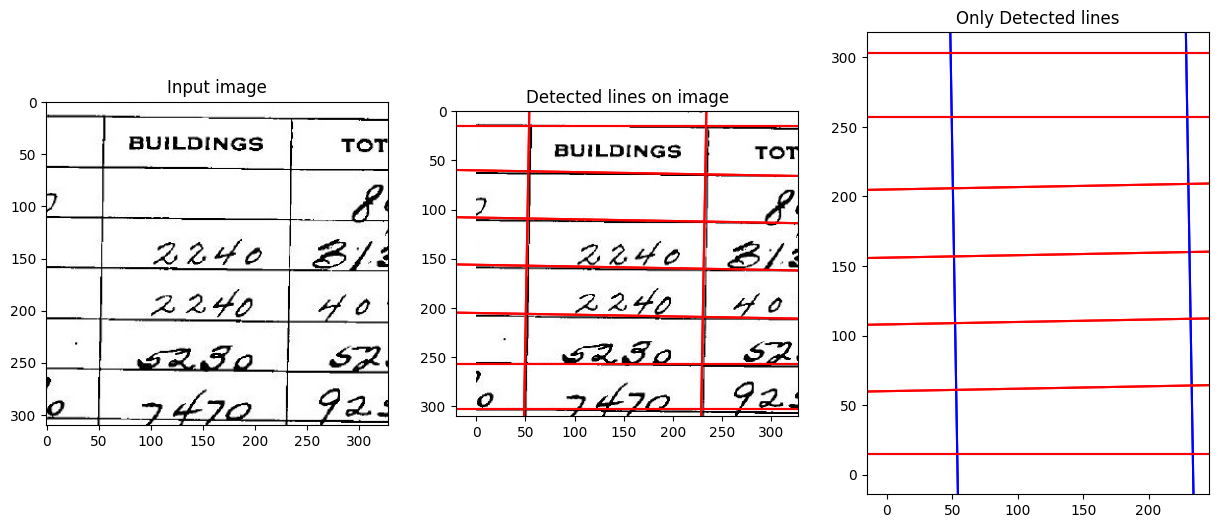

In [171]:
# Preprocessing for Hough
gray = cv2.cvtColor(cropped_again,cv2.COLOR_BGR2GRAY)
thresh, thresh_image = cv2.threshold(gray, 165, 255, cv2.THRESH_BINARY)
gray = cv2.convertScaleAbs(thresh_image) # converting the scale
edges = cv2.Canny(gray, 0, 200)

# Parameters
thresh = 10
min_distance = 20

# Perform hough transformation
dimx, dimy = edges.shape
#diagonal = np.sqrt(dimx**2 + dimy**2)
#thresh = int(thresh * diagonal)
tested_angles = np.linspace(-np.pi, np.pi, 360, endpoint = False)

# Apply hough lines to retrieve all possible lines
h, theta, d = hough_line(edges, theta = tested_angles)

hspace, angles, dists = hough_line_peaks(h, theta, d, thresh, min_distance)

# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(cropped_again)
ax[0].set_title('Input image')

ax[1].imshow(cropped_again)
ax[1].set_title('Detected lines on image')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, thresh, min_distance)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red')


ax[2].set_title('Only Detected lines')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, thresh, min_distance)):
    x = np.tan(angle + np.pi/2)

    # Horizontal lines
    if x >= 0:
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red')

    # vertical lines
    else:
        (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
        ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='blue')


hspace, angles, dists = hough_line_peaks(h, theta, d, thresh, min_distance)

num_lines = len(angles)

print(f"{num_lines} lines were detected")



C:\Users\mihir\AppData\Local\Temp\ipykernel_1072\1034428143.py:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(A, b)[0] # use lstsq to solve Ax = b, not inv() which is unstable


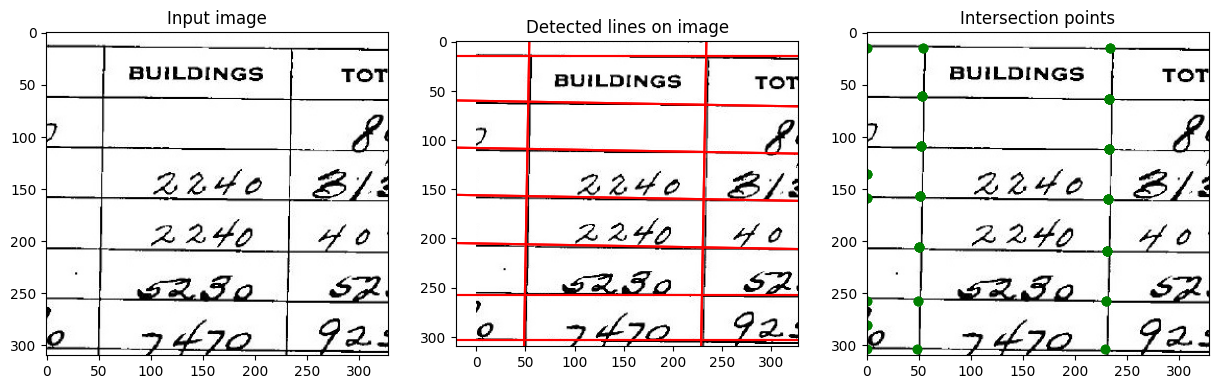

In [200]:
## Finding the intersection points

## First segment the lines into vertical vs horizontal, based on threshold system used above:
segmented = {}

hspace, angles, dists = hough_line_peaks(h, theta, d, thresh, min_distance)

for i in range(len(angles)):
    angle = angles[i]
    x = np.tan(angle + np.pi/2)
    if x >= 0:
        segmented[i] = 1 # horizontal line
    else:
        segmented[i] = 0 # vertical line


# Function sourced from this answer: https://stackoverflow.com/a/70371736

def hough_inter(theta1, rho1, theta2, rho2):
    A = np.array([[np.cos(theta1), np.sin(theta1)], 
                  [np.cos(theta2), np.sin(theta2)]])
    b = np.array([rho1, rho2])
    
    return np.linalg.lstsq(A, b)[0] # use lstsq to solve Ax = b, not inv() which is unstable


# Now loop through all combinations of lines, only checking for intersections if they are of different types
intersections = []

for i in range(len(angles) - 1):
    for j in range(1, len(angles)):
        
        if segmented[i] != segmented[j]: # check that we are only running algo for vertical / horizontal line pairs
            
            point = hough_inter(angles[i], dists[i], angles[j], dists[j])

            intersections.append(point)

        else:
            pass


# Check 

# Plotting results
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(cropped_again)
ax[0].set_title('Input image')

ax[1].imshow(cropped_again)
ax[1].set_title('Detected lines on image')
for _, angle, dist in zip(*hough_line_peaks(h, theta, d, thresh, min_distance)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi/2), color='red')

# Intersection points
ax[2].imshow(cropped_again)
ax[2].set_title('Intersection points')
ax[2].set_xlim(0, cropped_again.shape[1])
#ax[2].set_ylim(0, cropped_again.shape[0])
for i in intersections:
    ax[2].scatter(i[0], i[1], color='green')


## Goal: get the starting x,y coord, and get the width/height of each box



105 lines were detected


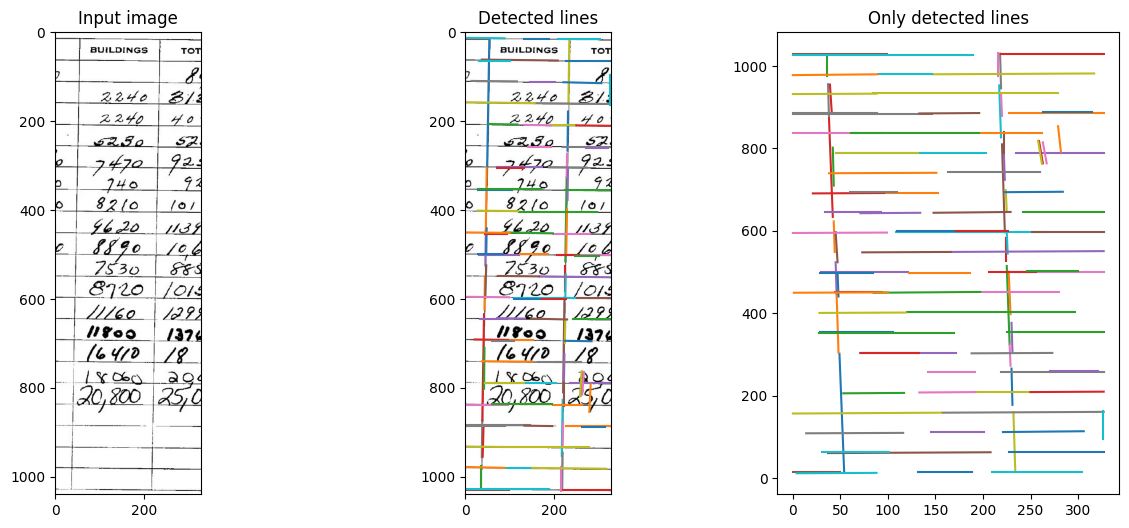

In [153]:
## Probabilistic hough transform
threshold = 100
#line_length = 5
#line_gap = 3

lines = probabilistic_hough_line(edges, threshold)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(cropped_again)
ax[0].set_title('Input image')

ax[1].imshow(cropped_again)
ax[1].set_title('Detected lines')

for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))

ax[2].set_title('Only detected lines')
for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

print(f'{len(lines)} lines were detected')
